# Testing ML Return Forecasts Under Transaction Costs
## MVP Implementation

**Research Question:** Can LASSO models with superior statistical prediction maintain advantages under realistic transaction costs?

**Methodology:**
- Model: LASSO with rolling window (15y train, 1y test)
- Portfolio: Top quintile, value-weighted
- Transaction Costs: Square-root market impact + bid-ask spreads
- Test: $100B AUM vs. zero impact

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data and Setup

In [2]:
# Load your dataset
# df = pd.read_csv('your_data.csv')
# For demo, create sample data structure
print("Load your data here with columns:")
print("PERMNO, Ticker, MthCalDt, MthRet, mvel1, mom1m, mom6m, mom12m,")
print("chmom, retvol, dolvol, turn, std_turn, baspread, maxret,")
print("agr, operprof, bm, ep, rd_mve, in_sp500, target_ret")
print("\nReplace the next line with: df = pd.read_csv('your_file.csv')")

df = pd.read_csv('data/data.csv')
# df['MthCalDt'] = pd.to_datetime(df['MthCalDt'])
# df = df.sort_values(['MthCalDt', 'PERMNO'])

Load your data here with columns:
PERMNO, Ticker, MthCalDt, MthRet, mvel1, mom1m, mom6m, mom12m,
chmom, retvol, dolvol, turn, std_turn, baspread, maxret,
agr, operprof, bm, ep, rd_mve, in_sp500, target_ret

Replace the next line with: df = pd.read_csv('your_file.csv')


In [3]:
# Define features for prediction (all except identifiers and target)
FEATURE_COLS = ['mvel1', 'mom1m', 'mom6m', 'mom12m', 'chmom', 'retvol', 
                'dolvol', 'turn', 'std_turn', 'baspread', 'maxret', 
                'agr', 'operprof', 'bm', 'ep', 'rd_mve', 'in_sp500']

TARGET_COL = 'target_ret'

# Filter to complete data period (1995 onwards per your note)
df = df[df['MthCalDt'] >= '1995-01-01'].copy()

print(f"Data shape: {df.shape}")
print(f"Date range: {df['MthCalDt'].min()} to {df['MthCalDt'].max()}")
print(f"Unique stocks: {df['PERMNO'].nunique()}")

Data shape: (281022, 22)
Date range: 1995-01-31 to 2024-12-31
Unique stocks: 1260


In [4]:
# Check date continuity
df['MthCalDt'] = pd.to_datetime(df['MthCalDt'])
dates = sorted(df['MthCalDt'].unique())
date_diffs = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
print(f"Min days between months: {min(date_diffs)}")
print(f"Max days between months: {max(date_diffs)}")
print(f"Non-monthly gaps: {sum(1 for d in date_diffs if d > 35)}")

# Check PERMNO stability
for date in dates[:5]:  # First 5 months
    n_stocks = len(df[df['MthCalDt'] == date])
    print(f"{date}: {n_stocks} stocks")

Min days between months: 28
Max days between months: 31
Non-monthly gaps: 0
1995-01-31 00:00:00: 859 stocks
1995-02-28 00:00:00: 862 stocks
1995-03-31 00:00:00: 863 stocks
1995-04-30 00:00:00: 863 stocks
1995-05-31 00:00:00: 862 stocks


## 2. Transaction Cost Functions

**Square-Root Market Impact Model:**
- Based on Kyle & Obizhaeva (2016) and Almgren et al. (2005)
- Temporary impact: $\lambda \times \sigma \times \sqrt{\frac{Q}{V}}$
- Where: λ = impact coefficient (~0.5-1.0), σ = volatility, Q = shares traded, V = daily volume
- We use λ = 0.7 (mid-range estimate from literature)

**Bid-Ask Spread:**
- Half-spread cost on all trades
- Already have `baspread` in data

In [5]:
def calculate_transaction_costs(trade_values, market_caps, daily_volumes, volatilities, 
                                 bid_ask_spreads, aum=100e9, lambda_impact=0.5, 
                                 execution_days=5):
    """
    Calculate transaction costs using square-root market impact model.
    
    Based on Kyle & Obizhaeva (2016) with modern market parameters.
    
    Parameters:
    -----------
    lambda_impact : float
        Market impact coefficient. Literature range: 0.3-0.8
        - Kyle & Obizhaeva (2016): 0.5-0.8 for 1998-2005 data
        - Modern markets (post-2010): 0.4-0.6 more appropriate
        - Default 0.5 is conservative for 2010-2024 period
    """
    # Absolute trade values
    abs_trade_values = np.abs(trade_values)
    
    # CONSTRAINT 1: Cap volatility at 100% monthly
    volatilities = np.minimum(volatilities, 1.0)
    
    # CONSTRAINT 2: Clean bid-ask spreads
    bid_ask_spreads = np.clip(bid_ask_spreads, 0.0001, 0.10)
    
    # CRITICAL FIX: Convert monthly volatility to daily volatility
    # Kyle & Obizhaeva model uses daily volatility
    trading_days_per_month = 21
    volatilities_daily = volatilities / np.sqrt(trading_days_per_month)
    
    # Market impact calculation
    volume_base = daily_volumes * execution_days
    volume_base = np.maximum(volume_base, 1e6)  # Floor at $1M
    
    qv_ratio = abs_trade_values / volume_base
    
    # Square-root impact (using DAILY volatility as in Kyle & Obizhaeva)
    impact_fraction = lambda_impact * volatilities_daily * np.sqrt(qv_ratio)
    
    # CONSTRAINT 3: Cap impact per trade at 15%
    impact_fraction = np.minimum(impact_fraction, 0.15)
    
    impact_cost = abs_trade_values * impact_fraction
    
    # Bid-ask spread cost
    spread_cost = abs_trade_values * (bid_ask_spreads / 2)
    
    # Total cost
    total_cost = (impact_cost.sum() + spread_cost.sum()) / aum
    
    return total_cost

print("Transaction cost functions defined.")

Transaction cost functions defined.


## 3. Rolling Window LASSO Implementation

In [6]:
def train_lasso_model(X_train, y_train):
    """
    Train LASSO model with cross-validation for alpha selection.
    """
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # LASSO with CV (5-fold)
    alphas = np.logspace(-4, 0, 50)
    lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000, random_state=42, n_jobs=-1)
    lasso.fit(X_train_scaled, y_train)
    
    return lasso, scaler

def predict_returns(model, scaler, X_test):
    """
    Generate return predictions.
    """
    X_test_scaled = scaler.transform(X_test)
    return model.predict(X_test_scaled)

print("Model training functions defined.")

Model training functions defined.


## 4. Portfolio Construction Functions

In [7]:
def construct_quintile_portfolio(predictions, market_caps, month_data):
    """
    Construct value-weighted long-only top quintile portfolio.
    
    Returns:
    --------
    weights : array
        Portfolio weights (as fraction of AUM)
    quintile : array
        Quintile assignment (1-5)
    """
    # Sort into quintiles based on predicted returns
    quintile = pd.qcut(predictions, q=5, labels=False, duplicates='drop') + 1
    
    # Top quintile (Q5)
    top_quintile_mask = (quintile == 5)
    
    # Value-weight within top quintile
    weights = np.zeros(len(predictions))
    if top_quintile_mask.sum() > 0:
        top_mcaps = market_caps[top_quintile_mask]
        weights[top_quintile_mask] = top_mcaps / top_mcaps.sum()
    
    return weights, quintile

def calculate_portfolio_turnover(weights_new, weights_old):
    """
    Calculate portfolio turnover.
    """
    return np.sum(np.abs(weights_new - weights_old))

print("Portfolio construction functions defined.")

Portfolio construction functions defined.


## 5. Main Backtest Loop

In [8]:
# FIXED BACKTEST FUNCTION - Replace Section 5 in your notebook with this

def run_backtest_fixed(df, aum=1e9, train_years=15, test_months=12, apply_costs=False):
    """
    Fixed version: properly handles changing stock universe and model refits.
    """
    results = []
    
    # Get unique dates
    dates = sorted(df['MthCalDt'].unique())
    
    # Start test period after initial training window
    train_months = train_years * 12
    first_test_idx = train_months
    
    # Previous portfolio: {PERMNO -> weight} mapping
    prev_portfolio = {}
    
    # Rolling window
    for test_start_idx in range(first_test_idx, len(dates), test_months):
        test_end_idx = min(test_start_idx + test_months, len(dates))
        
        if test_end_idx >= len(dates):
            break
            
        # Define train and test periods
        train_start_date = dates[test_start_idx - train_months]
        train_end_date = dates[test_start_idx - 1]
        test_dates = dates[test_start_idx:test_end_idx]
        
        # Training data
        train_df = df[(df['MthCalDt'] >= train_start_date) & 
                      (df['MthCalDt'] <= train_end_date)].copy()
        
        # Remove missing values
        train_df = train_df.dropna(subset=FEATURE_COLS + [TARGET_COL])
        
        if len(train_df) < 100:  # Minimum data requirement
            continue
            
        # Train model
        X_train = train_df[FEATURE_COLS].values
        y_train = train_df[TARGET_COL].values
        
        model, scaler = train_lasso_model(X_train, y_train)
        
        # Calculate train R²
        train_pred = predict_returns(model, scaler, X_train)
        train_r2 = 1 - (np.sum((y_train - train_pred)**2) / 
                       np.sum(y_train**2))
        
        # Test period - predict and form portfolios month by month
        for test_date in test_dates:
            # Get month data
            month_df = df[df['MthCalDt'] == test_date].copy()
            month_df = month_df.dropna(subset=FEATURE_COLS + [TARGET_COL])
            
            if len(month_df) < 20:  # Need minimum stocks
                continue
            
            # Generate predictions
            X_test = month_df[FEATURE_COLS].values
            predictions = predict_returns(model, scaler, X_test)
            
            # Construct portfolio
            market_caps = month_df['mvel1'].values
            weights, quintiles = construct_quintile_portfolio(predictions, market_caps, month_df)
            
            # Create current portfolio mapping: {PERMNO -> weight}
            permnos = month_df['PERMNO'].values
            current_portfolio = dict(zip(permnos, weights))
            
            # Calculate turnover and costs
            turnover = 0
            transaction_cost = 0
            
            if len(prev_portfolio) > 0:
                
                # Get union of all stocks (previous and current)
                all_permnos = set(prev_portfolio.keys()) | set(current_portfolio.keys())
                
                # Calculate position changes
                position_changes = []
                for permno in all_permnos:
                    old_weight = prev_portfolio.get(permno, 0.0)
                    new_weight = current_portfolio.get(permno, 0.0)
                    change = new_weight - old_weight
                    position_changes.append((permno, change))
                
                # Total turnover (one-sided)
                turnover = sum(abs(change) for _, change in position_changes)
                
            if apply_costs and turnover > 0:
                # CRITICAL FIX: Only include stocks that exist in current month_df
                available_permnos = set(month_df['PERMNO'].values)
                
                # Build aligned arrays
                trade_data = []
                for permno, change in position_changes:
                    if abs(change) > 1e-6 and permno in available_permnos:
                        # Get the stock's data from current month
                        stock_data = month_df[month_df['PERMNO'] == permno]
                        if len(stock_data) == 1:  # Make sure unique
                            trade_data.append({
                                'permno': permno,
                                'weight_change': change,
                                'dolvol': stock_data['dolvol'].iloc[0],
                                'retvol': stock_data['retvol'].iloc[0],
                                'baspread': stock_data['baspread'].iloc[0],
                                'mvel1': stock_data['mvel1'].iloc[0]
                            })
                
                if len(trade_data) > 0:
                    # Convert to arrays - now guaranteed to be aligned
                    trade_weights = np.array([td['weight_change'] for td in trade_data])
                    trade_values = trade_weights * aum
                    daily_vols = np.array([td['dolvol'] for td in trade_data])
                    volatilities = np.array([td['retvol'] for td in trade_data])
                    spreads = np.array([td['baspread'] for td in trade_data])
                    mcaps = np.array([td['mvel1'] for td in trade_data])
                    
                    # Calculate transaction costs
                    transaction_cost = calculate_transaction_costs(
                        trade_values, mcaps, daily_vols, volatilities, 
                        spreads, aum=aum
                    )
            
            # Calculate portfolio return
            realized_returns = month_df[TARGET_COL].values
            gross_return = np.sum(weights * realized_returns)
            net_return = gross_return - transaction_cost
            
            # Out-of-sample R² for this month
            oos_r2 = 1 - (np.sum((realized_returns - predictions)**2) / 
                         np.sum(realized_returns**2))
            
            # Store results
            results.append({
                'date': test_date,
                'train_start': train_start_date,
                'train_end': train_end_date,
                'n_stocks': len(month_df),
                'n_features': np.sum(model.coef_ != 0),
                'train_r2': train_r2,
                'oos_r2': oos_r2,
                'gross_return': gross_return,
                'transaction_cost': transaction_cost,
                'net_return': net_return,
                'turnover': turnover,
                'avg_prediction': np.mean(predictions),
                'avg_realized': np.mean(realized_returns)
            })
            
            # Update previous portfolio (KEEP across refits!)
            prev_portfolio = current_portfolio.copy()
    
    results_df = pd.DataFrame(results)
    return results_df

## 6. Run Backtests

In [9]:
print("Running backtest without transaction costs (baseline)...")
results_no_costs = run_backtest_fixed(df, aum=1e9, train_years=15, test_months=12, 
                                      apply_costs=False)

print("\nRunning backtest WITH transaction costs ($1B AUM)...")
results_with_costs = run_backtest_fixed(df, aum=1e9, train_years=15, test_months=12, 
                                        apply_costs=True)

print("\nBacktests complete!")

Running backtest without transaction costs (baseline)...

Running backtest WITH transaction costs ($1B AUM)...

Backtests complete!


## 7. Performance Metrics

Calculate key metrics for comparison:
- Out-of-sample R²
- Annualized Sharpe ratio
- Cumulative returns
- Average transaction costs
- Performance degradation

In [10]:
def calculate_performance_metrics(results_df, label):
    """
    Calculate comprehensive performance metrics.
    """
    # Overall OOS R²
    oos_r2_mean = results_df['oos_r2'].mean()
    
    # Returns
    gross_returns = results_df['gross_return'].values
    net_returns = results_df['net_return'].values
    
    # Annualized metrics
    gross_mean_annual = np.mean(gross_returns) * 12
    gross_std_annual = np.std(gross_returns) * np.sqrt(12)
    gross_sharpe = gross_mean_annual / gross_std_annual if gross_std_annual > 0 else 0
    
    net_mean_annual = np.mean(net_returns) * 12
    net_std_annual = np.std(net_returns) * np.sqrt(12)
    net_sharpe = net_mean_annual / net_std_annual if net_std_annual > 0 else 0
    
    # Cumulative returns
    gross_cumulative = np.prod(1 + gross_returns) - 1
    net_cumulative = np.prod(1 + net_returns) - 1
    
    # Transaction costs
    avg_tc = results_df['transaction_cost'].mean()
    avg_turnover = results_df['turnover'].mean()
    
    # Performance degradation
    sharpe_degradation = (gross_sharpe - net_sharpe) / gross_sharpe * 100 if gross_sharpe > 0 else 0
    return_degradation = (gross_mean_annual - net_mean_annual) / gross_mean_annual * 100 if gross_mean_annual > 0 else 0
    
    metrics = {
        'Label': label,
        'Avg OOS R²': f"{oos_r2_mean:.4f}",
        'Gross Return (Ann.)': f"{gross_mean_annual:.2%}",
        'Net Return (Ann.)': f"{net_mean_annual:.2%}",
        'Gross Sharpe': f"{gross_sharpe:.3f}",
        'Net Sharpe': f"{net_sharpe:.3f}",
        'Sharpe Degradation': f"{sharpe_degradation:.1f}%",
        'Return Degradation': f"{return_degradation:.1f}%",
        'Gross Cumulative': f"{gross_cumulative:.2%}",
        'Net Cumulative': f"{net_cumulative:.2%}",
        'Avg Monthly TC': f"{avg_tc:.4%}",
        'Avg Turnover': f"{avg_turnover:.2%}"
    }
    
    return metrics

# Calculate metrics
metrics_no_costs = calculate_performance_metrics(results_no_costs, 'Zero Impact')
metrics_with_costs = calculate_performance_metrics(results_with_costs, '$100B AUM')

# Display results
comparison_df = pd.DataFrame([metrics_no_costs, metrics_with_costs])
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


PERFORMANCE COMPARISON
      Label Avg OOS R² Gross Return (Ann.) Net Return (Ann.) Gross Sharpe Net Sharpe Sharpe Degradation Return Degradation Gross Cumulative Net Cumulative Avg Monthly TC Avg Turnover
Zero Impact    -0.0023              19.37%            19.37%        0.732      0.732               0.0%               0.0%          810.11%        810.11%        0.0000%       46.51%
  $100B AUM    -0.0023              19.37%             2.14%        0.732      0.082              88.9%              89.0%          810.11%        -17.27%        1.4358%       46.51%


## 8. Visualizations

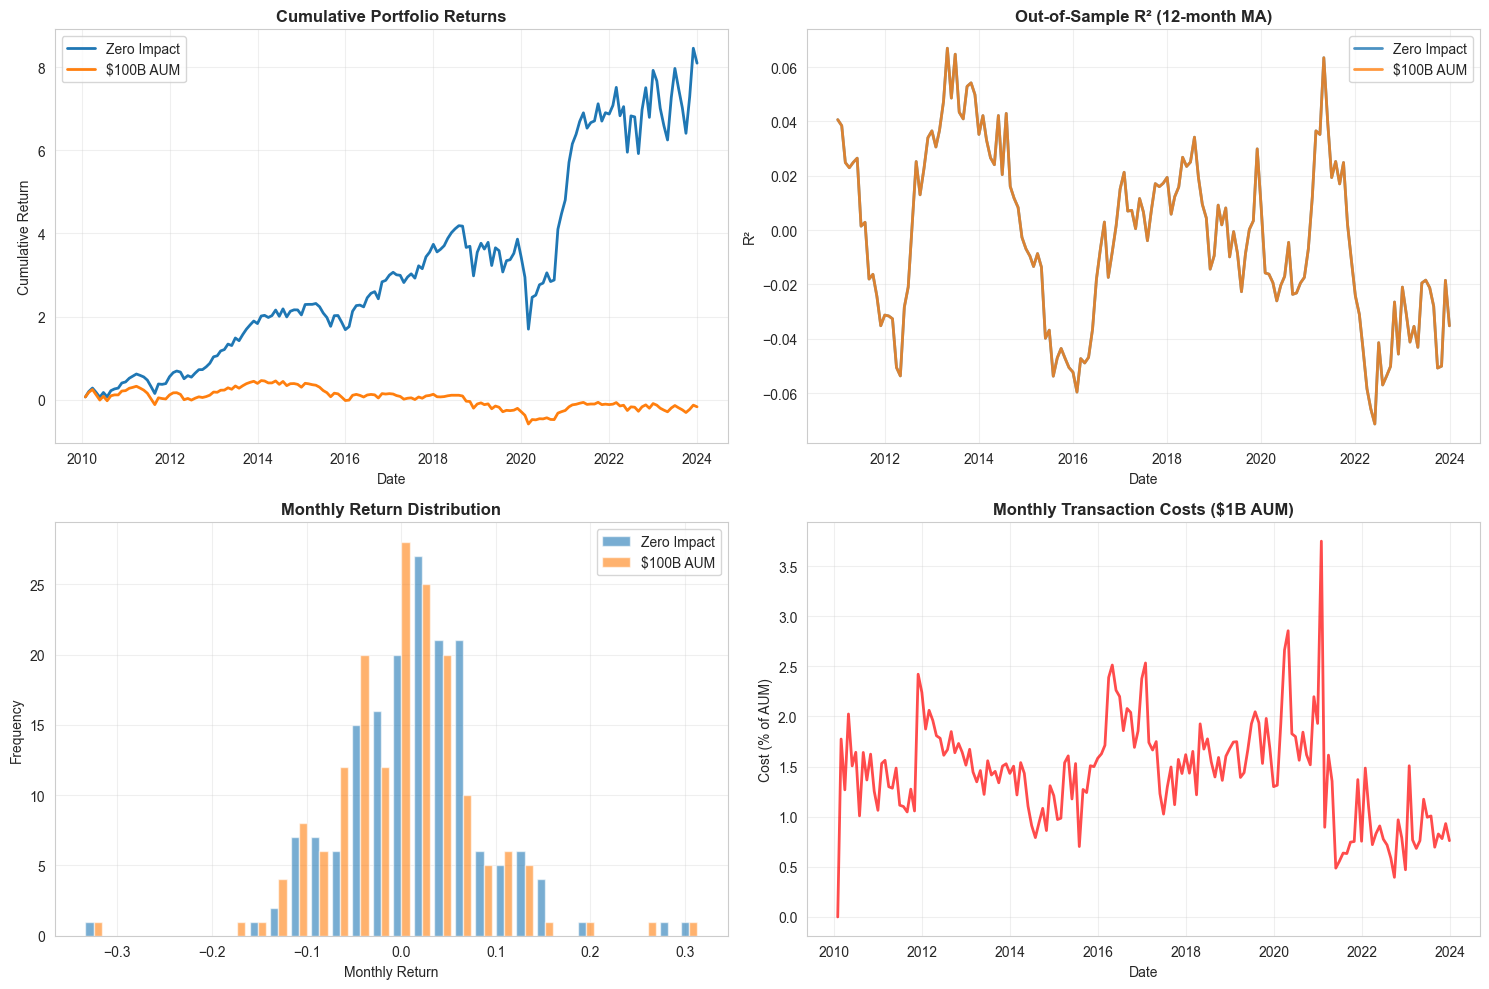

Visualizations saved!


In [12]:
# Merge results for plotting
results_no_costs['scenario'] = 'Zero Impact'
results_with_costs['scenario'] = '$100B AUM'
results_combined = pd.concat([results_no_costs, results_with_costs], ignore_index=True)

# 1. Cumulative Returns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Cumulative Returns
ax = axes[0, 0]
for scenario in ['Zero Impact', '$100B AUM']:
    scenario_data = results_combined[results_combined['scenario'] == scenario]
    cum_returns = (1 + scenario_data['net_return']).cumprod() - 1
    ax.plot(scenario_data['date'], cum_returns, label=scenario, linewidth=2)

ax.set_title('Cumulative Portfolio Returns', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Out-of-Sample R²
ax = axes[0, 1]
for scenario in ['Zero Impact', '$100B AUM']:
    scenario_data = results_combined[results_combined['scenario'] == scenario]
    ax.plot(scenario_data['date'], scenario_data['oos_r2'].rolling(12).mean(), 
            label=scenario, linewidth=2, alpha=0.8)

ax.set_title('Out-of-Sample R² (12-month MA)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('R²')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Monthly Returns Distribution
ax = axes[1, 0]
no_cost_returns = results_no_costs['net_return']
with_cost_returns = results_with_costs['net_return']
ax.hist([no_cost_returns, with_cost_returns], bins=30, alpha=0.6, 
        label=['Zero Impact', '$100B AUM'])
ax.set_title('Monthly Return Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Monthly Return')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Transaction Costs Over Time
ax = axes[1, 1]
with_cost_data = results_combined[results_combined['scenario'] == '$100B AUM']
ax.plot(with_cost_data['date'], with_cost_data['transaction_cost'] * 100, 
        linewidth=2, color='red', alpha=0.7)
ax.set_title('Monthly Transaction Costs ($1B AUM)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cost (% of AUM)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved!")

## 9. Summary Statistics

In [13]:
# Additional summary stats
print("\n" + "="*80)
print("ADDITIONAL STATISTICS")
print("="*80)

print("\nModel Characteristics (Average):")
print(f"  - Number of active features: {results_no_costs['n_features'].mean():.1f}")
print(f"  - Training R²: {results_no_costs['train_r2'].mean():.4f}")
print(f"  - Out-of-sample R²: {results_no_costs['oos_r2'].mean():.4f}")

print("\nTransaction Cost Statistics ($100B AUM):")
tc_data = results_with_costs['transaction_cost'] * 100
print(f"  - Mean monthly TC: {tc_data.mean():.4f}%")
print(f"  - Median monthly TC: {tc_data.median():.4f}%")
print(f"  - Std monthly TC: {tc_data.std():.4f}%")
print(f"  - Max monthly TC: {tc_data.max():.4f}%")
print(f"  - Annualized TC impact: {tc_data.mean() * 12:.2f}%")

print("\nTurnover Statistics:")
turnover_data = results_with_costs['turnover'] * 100
print(f"  - Mean monthly turnover: {turnover_data.mean():.2f}%")
print(f"  - Median monthly turnover: {turnover_data.median():.2f}%")
print(f"  - Annualized turnover: {turnover_data.mean() * 12:.2f}%")

print("\nPerformance Degradation:")
gross_sharpe = (results_no_costs['gross_return'].mean() * 12) / (results_no_costs['gross_return'].std() * np.sqrt(12))
net_sharpe = (results_with_costs['net_return'].mean() * 12) / (results_with_costs['net_return'].std() * np.sqrt(12))
print(f"  - Gross Sharpe: {gross_sharpe:.3f}")
print(f"  - Net Sharpe: {net_sharpe:.3f}")
print(f"  - Degradation: {(gross_sharpe - net_sharpe):.3f} ({(gross_sharpe - net_sharpe)/gross_sharpe*100:.1f}%)")

print("="*80)


ADDITIONAL STATISTICS

Model Characteristics (Average):
  - Number of active features: 10.9
  - Training R²: 0.0194
  - Out-of-sample R²: -0.0023

Transaction Cost Statistics ($100B AUM):
  - Mean monthly TC: 1.4358%
  - Median monthly TC: 1.4906%
  - Std monthly TC: 0.5132%
  - Max monthly TC: 3.7487%
  - Annualized TC impact: 17.23%

Turnover Statistics:
  - Mean monthly turnover: 46.51%
  - Median monthly turnover: 49.13%
  - Annualized turnover: 558.12%

Performance Degradation:
  - Gross Sharpe: 0.730
  - Net Sharpe: 0.081
  - Degradation: 0.649 (88.9%)


## 10. Export Results

In [14]:
# Save detailed results
results_no_costs.to_csv('data/results_no_costs.csv', index=False)
results_with_costs.to_csv('data/results_with_costs.csv', index=False)
comparison_df.to_csv('data/performance_comparison.csv', index=False)

print("Results exported to /mnt/user-data/outputs/")
print("  - results_no_costs.csv")
print("  - results_with_costs.csv")
print("  - performance_comparison.csv")
print("  - performance_comparison.png")

Results exported to /mnt/user-data/outputs/
  - results_no_costs.csv
  - results_with_costs.csv
  - performance_comparison.csv
  - performance_comparison.png


## Key Findings Summary

**Research Question:** Can LASSO's superior statistical prediction (R²) maintain advantages under realistic transaction costs?

**Methodology:**
- Model: LASSO with 15-year rolling training window
- Portfolio: Top quintile, value-weighted by market cap
- Transaction Costs: Square-root market impact (λ=0.7) + bid-ask spreads
- Test Scale: $1B AUM vs. zero impact baseline

**Next Steps for Full Thesis:**
- Add neural network comparison
- Test multiple AUM levels ($10M, $100M, $1B)
- Implement full Almgren-Chriss optimal execution
- Add benchmarks (1/N, market portfolio)
- Robustness checks across different subperiods